
![a robot](https://serve-md.charlesdlandau.net/img/robot-rrmonkey-unsplash.jpg)

### Drive a Tank With Python

Previously, I reviewed core concepts in Reinforcement Learning (RL) and introduced important parts of the OpenAI Gym API. You can review that introduction [here](https://dev.to/charlesdlandau/train-robots-to-shoot-lazers-at-aliens-with-software-funded-by-elon-musk-and-microsoft-1m34).

In this installment we'll train a tank commander. I'm sharing a bunch of the code for this project [here](https://github.com/CharlesDLandau/rlNotebooks)

#### Side note: OpenAI Gym installation

...is somewhat painful. Many online notebook services like [colab](https://colab.research.google.com) and [Kaggle](https://kaggle.org) don't allow you to install some of the OpenAI environments, so I'm going to stick to Atari for now. If you're interested in trying to set up OpenAI gym with more flexibility, you might start with [this interesting write-up](https://medium.com/coinmonks/preparing-a-headless-environment-for-openais-gym-with-docker-and-tensorflow-1bd0e0d31663).

In order to write agents that actually take the game screen into account when making decisions, we'll need to update our `run_job` utility from last time:

```python
    action = model.decision_function(obs=observation, env=env)
```

And our RandomAgent will need to be modified accordingly:

In [ ]:
class RandomAgentContainer:
    """A model that takes random actions and doesn't learn"""
    
    def __init__(self):
        pass
    
    def decision_function(self, obs=None, env=None):
        if env:
            return env.action_space.sample()
        else:
            return 0
    
    def train_on_history(self, history):
        pass
    

model = RandomAgentContainer()

Now we can use our RandomAgent to explore all the information that our job creates.

In [ ]:
result = run_job("Robotank-v0", model,
        10000, episodes_per_train=0);

result.keys()

dict_keys(['history', 'env', 'parameters'])

Our job produced video of the game being played, as well as a history of images, actions, predictions, and rewards. It also saved the environment object from OpenAI Gym.

Let's begin by trying to understand our observations in a video:

```python
render_video(0, result['env']);
```

![GIF OF RANDOMAGENT](https://serve-md.charlesdlandau.net/img/tank_lesson_randomagent.gif)

If, like me, you have never played Robot Tank on an Atari... you can [read the manual](http://www.atarimania.com/game-atari-2600-vcs-robot-tank_s6928.html)! You can learn about the heads up display and more.

So anyway, it looks like the image has a bunch of noise in it. Let's see if we can extract any of that...

In [ ]:
import matplotlib
from matplotlib.image import imread
from matplotlib.pyplot import imshow

```python
observation_sample = [im['observation'] for im in result.get('history')]

imshow(observation_sample[0])
```
![robotank_viewport](https://serve-md.charlesdlandau.net/img/robotank-viewport.png)

So using the ticks on the axes and with a little trial and error we can find the bounding boxes for the radar panel and the periscope.

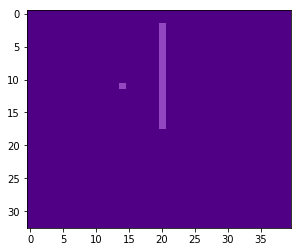

In [ ]:
imshow(observation_sample[0][139:172, 60:100, :])

So, we can certainly crop this image and worry less about the noise...

In [ ]:
radar_bounding_box = ((139, 172), (60, 100), (None))

From reading the manual we know that one of the four indicators bracketing this radar display is "R" for "radar." In other words, we' can't rely on radar as the only input, because all of those indicators represent subsystems that can be disabled.

Let's also take a bounding box for the periscope:

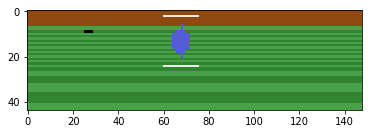

In [ ]:
imshow(observation_sample[0][80:124, 12:160, :])

In [ ]:
peri_bounding_box=((80, 124), (12, 160), (None))

Let's also check the `info` field because it sometimes has observation data.

In [ ]:
result.get('history')[0].get('info')

{'ale.lives': 4}

I'm going to intentionally ignore the V, C, R, T boxes and we can always reintrouduce them later if we think a performance gain in in in the offing. You saw in the manual how they work so I don't think it's a cause for concern...

Let's also try to understand the action space.

In [ ]:
env = result['env']

print(env.action_space)

Discrete(18)


Hmm...not helpful at all. But that's what you'd naturally think to do... It turns out that extracting action meanings has its own namespace in the `gym` API.

In [ ]:
# https://ai.stackexchange.com/a/3557
env.unwrapped.get_action_meanings()

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE',
 'DOWNRIGHTFIRE',
 'DOWNLEFTFIRE']

So "NOOP" presumably means "no-op" i.e. "do nothing." The rest apparently constitute all the permutations of actions available to the client. This is what we would expect the action space to be. These are also **discrete** actions so we can code our model to take exactly one action per step.

Finally, let's visualize the rewards

In [ ]:
set([r['reward'] for r in result['history']]) # Unique rewards across history

{0.0, 1.0}

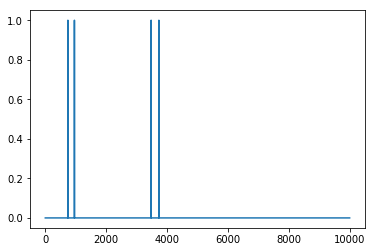

In [ ]:
import matplotlib.pyplot as plt
plt.plot([r['reward'] for r in result['history']])

Looks like the reward function is simply "score a hit=1 else 0". We can confirm by visualizing the observations at reward time.

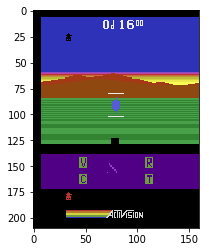

In [ ]:
# Observations when reward was given
reward_incidents = list(filter(lambda i: i['reward'], result['history']))

i = 0
imshow(reward_incidents[i]['observation'])

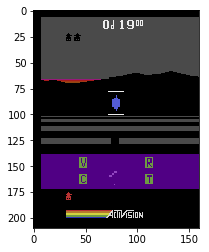

In [ ]:
i = 1
imshow(reward_incidents[i]['observation'])

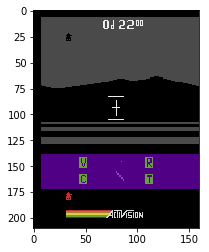

In [ ]:
i = 2
imshow(reward_incidents[i]['observation'])

They're all images that seem to be captured right after the tank scores a hit.

#### Writing the tank commander

##### The brain

The TankCommander agent needs to learn how to decide which action to take. So, we first need to give it a mechanism for learning. In this case, we're going to use a special kind of graph. In this graph there are three kinds of nodes:

1. Input nodes

    Which take our inputs and send signals to the nodes that they are connected to
 
2. Regular nodes

    These nodes can have many connections from other nodes (including input nodes.) Some connections are strong, and some connections are weak. This node uses the signals and the signal strength from all the connections to decide what signal to send along all of its own outgoing connections.
    
3. Output nodes

   These nodes are only different from regular nodes in that we read their signal.
   
The nodes are organized into "layers" that can share many connections and have a function in common for how they decide to aggregate and send signals.

Now, I've simplified a lot, but the graph that we're talking about, if properly organized, is a deep learning neural net. To create one we can use `tensorflow` like so:


```python
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, preprocessing, callbacks
import numpy as np
import random

inputs = layers.Input(shape=(44, 148, 3))
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.BatchNormalization(axis=-1)(x) # Channels @ -1
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dense(64)(x)
x = layers.Activation('sigmoid')(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.Dropout(0.02)(x)
x = layers.Dense(18, activation='linear')(x)
model = models.Model(inputs, x)
model.compile(optimizer='sgd',
      loss='mae',
      metrics=['accuracy'])
```

Let's break it down:

```python

inputs = layers.Input(shape=(44, 148, 3))
```

You'll recall that this is the dimensions for one of our periscope images. These map to our input nodes.


```python
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.BatchNormalization(axis=-1)(x) # Channels @ -1
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dense(64)(x)
x = layers.Activation('sigmoid')(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.Dropout(0.02)(x)
x = layers.Dense(18, activation='linear')(x)
model = models.Model(inputs, x)
```

This establishes layers of regular nodes in our graph and their interactions. It's pretty fancy.

```python
model.compile(optimizer='sgd',
      loss='mae',
      metrics=['accuracy'])
```

Finally we `compile` the model, giving it some special parameters. To teach our graph to drive a tank, we need to call the `fit` method e.g. `model.fit(data, correct_prediction)`. Each time this happens, our model goes back and updates the strength (aka the 'weight') of the regular connections. The fancy name for this is "backpropagation." Anyway, the parameters of `model.compile` help determine how backpropagation is executed.

##### The Experiences

Now that we have a brain, the brain needs experiences to train on. As we know from our manual and our little exploration of the data, each episode maps to one full game of Robot Tank. However, in each game the player gets several tanks and if a tank is destroyed, the player simply "respawns" in a new tank. So the episode is actually not the smallest unit of experience, rather, it's the in-game "life" of a single tank.

We can extract this from:

```python

episodes = [list(filter(lambda h: h["episode"]==e , history)
                      ) for e in range(n_episodes)
]

game_lives = [
            list(
              filter(lambda h: h.get('info').get('ale.lives')==l, episode)
        ) for l in range(5)
]

```

For each of these lives we can get a cumulative reward (how many hits scored before the life ends.)

```python

        rewards = [obs.get('reward') for obs in game_life]
        cum_rewards = sum(rewards)
```

And using this number we can determine how strongly we want our brain to react to this experience

```python
        # Positive experience
        if cum_rewards:
            nudge = cum_rewards * 0.03
        # Negative experience
        else:
           nudge = 0 - 0.03
```

Now, for a given step, we can:

1. Take our original `action`, `prediction`, and periscope `image` as data
2. `nudge` our `prediction` only at the `action` index, since we can only learn from the actions we have taken.
3. Call `model.fit(image, prediction_with_nudge)`

To visualize the problem with this, imagine you are tasked with riding a bike down a mountain blindfolded. As you miraculously ride down the mountain without killing yourself, you may reach a point where you seem to have reached the bottom. In any direction you try to go, you must pedal uphill. You take your blindfold off only to realize that you've barely gone a mile, and that you still have far to go before you reach the base of the mountain. The fancy term for this is a "local minimum."

![https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Extrema_example.svg/600px-Extrema_example.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Extrema_example.svg/600px-Extrema_example.svg.png)

To address this we can just force the commander to randomly take actions sometimes:

```python
for obs in game_life:

    action, prediction = obs.get('action')
    if self.epsilon and (random.uniform(0, 1.0) < self.epsilon):
      action = random.randrange(18)

    # Copy
    update = list(prediction)

    # Update only the target action
    update[0][action] = update[0][action] + displacement
```

With only 120k steps, our tank already seemed decided on a strategy:

![converging_gif](https://serve-md.charlesdlandau.net/img/tank_lesson_converging.gif)

As you can see, turning left is powerful in Robotank -- a whole squadron killed!

![zoolander_turns_left](https://media.giphy.com/media/qJsJI0MhazjGw/giphy.gif)

...but then it dies. I think this is pretty strong for a stumpy model trained only on the periscope viewport. Time permitting, I may continue to tinker with this one -- increasing the epsilon value, tinkering with the graph parameters, and adding views, all could help nudge the tank commander towards a more nuanced strategy.

Anyway you've learned a bit about implementing DL with RL in Python. You learned:

1. DL basic concepts
2. Exploratory data analysis for RL
3. Selectively applying rewards to specific actions, and smallest divisible units of experience
4. Introducing random actions to help explore the "action space"

Thanks for reading! Reach out with any questions.